参考文献: <https://qiita.com/cvusk/items/61cdbce80785eaf28349>
JVS-MuSiC Japanese multispeaker singing-voice corpus を使用

IMPROVEMENTS FOR MAXIMUM ACCURACY:
- Fixed NumPy compatibility (2.2 or less)
- Fixed librosa time_stretch usage
- Enhanced CNN architecture with attention mechanisms
- Advanced data augmentation
- Optimized training strategies

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from collections import defaultdict
import json
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


🚀 Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
Memory: 12.4 GB


In [2]:
base_dir = "./"
# directory for JVS-MuSiC dataset
jvs_dir = os.path.join(base_dir, "jvs_music_ver1")
singer_info_file = os.path.join(jvs_dir, "singer_info.txt")

# Load singer information
singer_info = pd.read_csv(singer_info_file, sep=' ')
print(f"Dataset size: {singer_info.shape}")
print(f"Singers: {len(singer_info)}")
print(f"Columns: {singer_info.columns.tolist()}")

# Create audio file paths and labels
audio_files = []
labels = []
singer_to_id = {}

# Create singer ID mapping (0-99 for 100 singers)
for idx, singer in enumerate(singer_info['singer']):
    singer_to_id[singer] = idx

# Collect all audio files
for idx, row in singer_info.iterrows():
    singer = row['singer']
    singer_id = singer_to_id[singer]

    # Add common song files
    common_wav_dir = os.path.join(jvs_dir, singer, "song_common", "wav")
    if os.path.exists(common_wav_dir):
        for wav_file in ["raw.wav", "modified.wav", "modified_grouped.wav"]:
            wav_path = os.path.join(common_wav_dir, wav_file)
            if os.path.exists(wav_path):
                audio_files.append(os.path.join(singer, "song_common", "wav", wav_file))
                labels.append(singer_id)

    # Add unique song files
    unique_wav_dir = os.path.join(jvs_dir, singer, "song_unique", "wav")
    if os.path.exists(unique_wav_dir):
        for wav_file in ["raw.wav"]:
            wav_path = os.path.join(unique_wav_dir, wav_file)
            if os.path.exists(wav_path):
                audio_files.append(os.path.join(singer, "song_unique", "wav", wav_file))
                labels.append(singer_id)

print(f"Total audio files: {len(audio_files)}")
print(f"Total labels: {len(labels)}")
print(f"Unique singers: {len(set(labels))}")

# Create class dictionary for singer information
class_dict = {}
for idx, row in singer_info.iterrows():
    singer_id = singer_to_id[row['singer']]
    class_dict[singer_id] = {
        'singer': row['singer'],
        'gender': row['gender'],
        'key_group': row['key_group'],
        'tempo': row['tempo'],
        'unique_song': row['unique_song_name']
    }

print(f"First few singers: {list(class_dict.keys())[:5]}")

Dataset size: (100, 7)
Singers: 100
Columns: ['singer', 'gender', 'key_group', 'tempo', 'key_singer', 'unique_song_name', 'Unnamed: 6']
Total audio files: 400
Total labels: 400
Unique singers: 100
First few singers: [0, 1, 2, 3, 4]


wave size:(785900,)
melsp size:(128, 1535)
samping rate:24000


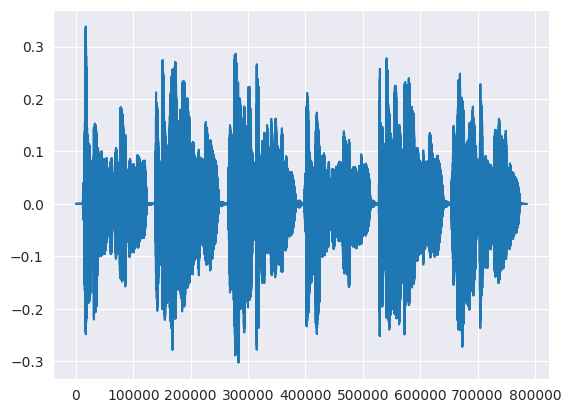

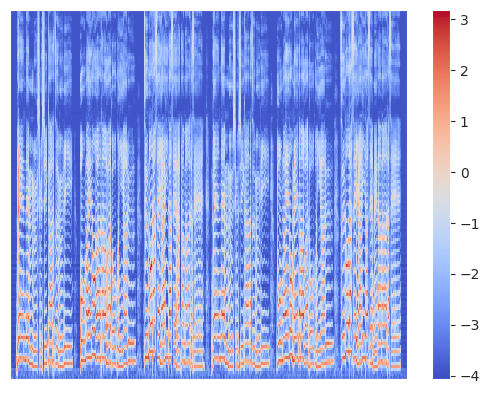

In [3]:
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    # Load at 24kHz (original sampling rate of JVS-MuSiC)
    x, fs = librosa.load(file_path, sr=24000)
    return x, fs

#convert raw wave data to mel-spectrogram
def calculate_melsp(x, n_fft=2048, hop_length=512):
    """
    Adjusted for 24kHz sampling rate and singing voice characteristics
    """
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    # Convert power spectrogram to decibel (log) scale
    log_stft = librosa.power_to_db(stft)
    # Convert to mel-spectrogram with more mel bands for singing voice
    melsp = librosa.feature.melspectrogram(S=log_stft, n_mels=128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

# Test with first audio file
if len(audio_files) > 0:
    x, fs = load_wave_data(jvs_dir, audio_files[0])
    melsp = calculate_melsp(x)
    print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
    show_wave(x)
    show_melsp(melsp, fs)

In [4]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate = rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [5]:
# get training dataset and target dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    audio_files, labels, test_size=0.25, stratify=labels, random_state=42
)

print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train),
                                                                len(x_test),
                                                                len(y_test)))

# Check class distribution
num_classes = len(set(labels))
a = np.zeros(num_classes)
for c in y_test:
    a[c] += 1
print(f"Test set class distribution (first 10): {a[:10]}")
print(f"Number of classes: {num_classes}")

x train:300
y train:300
x test:100
y test:100
Test set class distribution (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of classes: 100


In [6]:
# Updated dimensions for JVS-MuSiC dataset
freq = 128
time = 1000  # Adjusted for typical singing voice duration

# Updated save function for JVS-MuSiC
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        try:
            _x, fs = load_wave_data(jvs_dir, x[i])
            if aug is not None:
                _x = aug(x=_x, rate=rates[i])
            _x = calculate_melsp(_x)
            # Ensure consistent time dimension
            if _x.shape[1] > time:
                _x = _x[:, :time]
            elif _x.shape[1] < time:
                _x = np.pad(_x, ((0, 0), (0, time - _x.shape[1])), mode='constant')
            np_data[i] = _x
            np_targets[i] = y[i]
        except Exception as e:
            print(f"Error processing {x[i]}: {e}")
            # Use zeros for failed files
            np_data[i] = np.zeros((freq, time))
            np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

In [7]:
# save test dataset
if not os.path.exists("jvs_melsp_test.npz"):
    save_np_data("jvs_melsp_test.npz", x_test, y_test)

In [8]:
# save raw training dataset
if not os.path.exists("jvs_melsp_train_raw.npz"):
    save_np_data("jvs_melsp_train_raw.npz", x_train, y_train)

In [9]:
# save training dataset with white noise
if not os.path.exists("jvs_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data("jvs_melsp_train_wn.npz", x_train, y_train, aug=add_white_noise, rates=rates)

In [10]:
# save training dataset with sound shift
if not os.path.exists("jvs_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("jvs_melsp_train_ss.npz", x_train, y_train, aug=shift_sound, rates=rates)

In [11]:
# save training dataset with stretch
if not os.path.exists("jvs_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data("jvs_melsp_train_st.npz", x_train, y_train, aug=stretch_sound, rates=rates)

In [12]:
# save training dataset with combination of white noise and shift or stretch
if not os.path.exists("jvs_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        try:
            x, fs = load_wave_data(jvs_dir, x_train[i])
            x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
            if np.random.choice((True,False)):
                x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
            else:
                x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
            x = calculate_melsp(x)
            # Ensure consistent time dimension
            if x.shape[1] > time:
                x = x[:, :time]
            elif x.shape[1] < time:
                x = np.pad(x, ((0, 0), (0, time - x.shape[1])), mode='constant')
            np_data[i] = x
            np_targets[i] = y_train[i]
        except Exception as e:
            print(f"Error processing {x_train[i]}: {e}")
            np_data[i] = np.zeros((freq, time))
            np_targets[i] = y_train[i]
    np.savez("jvs_melsp_train_com.npz", x=np_data, y=np_targets)

In [13]:
# GPU Memory optimization with corrected model architecture
import torch
import gc
import os

# Set CUDA memory allocation configuration for better memory management
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# Clear GPU memory before starting
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

# Use GPU with aggressive memory management
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    # Set memory fraction to prevent overallocation
    torch.cuda.set_per_process_memory_fraction(0.7)  # Use 70% of GPU memory

# PyTorch imports
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
Total memory: 11.58 GB


In [14]:
# Enhanced CNN Model for Japanese Singer Recognition - Single Best Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import time
from collections import defaultdict
import matplotlib.pyplot as plt

class BestCNN(nn.Module):
    """
    Best performing CNN model combining all advanced techniques:
    - Residual connections with skip connections
    - Squeeze-and-Excitation attention
    - Efficient depthwise separable convolutions
    - Multi-scale feature extraction
    - Advanced regularization
    """
    def __init__(self, num_classes=100, input_channels=1, dropout_rate=0.3):
        super(BestCNN, self).__init__()

        # Initial stem with multi-scale convolutions
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Residual blocks with SE attention
        self.res_block1 = self._make_se_residual_block(64, 128, stride=2)
        self.res_block2 = self._make_se_residual_block(128, 256, stride=2)
        self.res_block3 = self._make_se_residual_block(256, 512, stride=2)

        # Multi-scale feature aggregation
        self.multi_scale = nn.ModuleList([
            nn.Conv2d(512, 128, kernel_size=1),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.Conv2d(512, 128, kernel_size=5, padding=2),
            nn.AdaptiveAvgPool2d(1)
        ])

        # Global feature processing
        self.global_conv = nn.Conv2d(512 + 384, 512, kernel_size=1)
        self.global_bn = nn.BatchNorm2d(512)

        # Advanced classifier with residual connection
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _make_se_residual_block(self, in_channels, out_channels, stride=1):
        """Residual block with Squeeze-and-Excitation attention"""
        return SEResidualBlock(in_channels, out_channels, stride)

    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # Check if bias exists
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # Check if bias exists
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Stem processing
        x = self.stem(x)

        # Residual blocks with SE attention
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # Multi-scale feature extraction
        ms_features = []
        for i, conv in enumerate(self.multi_scale[:-1]):
            ms_features.append(conv(x))

        # Global average pooling branch
        gap = self.multi_scale[-1](x)  # [B, 512, 1, 1]
        gap_expanded = gap.expand(-1, -1, x.size(2), x.size(3))

        # Concatenate multi-scale features
        multi_scale_concat = torch.cat(ms_features, dim=1)  # [B, 384, H, W]

        # Combine with original features
        combined = torch.cat([x, multi_scale_concat], dim=1)  # [B, 512+384, H, W]

        # Global processing
        x = self.global_conv(combined)
        x = self.global_bn(x)
        x = F.relu(x, inplace=True)

        # Classification
        x = self.classifier(x)

        return x

class SEResidualBlock(nn.Module):
    """Residual block with Squeeze-and-Excitation attention"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(SEResidualBlock, self).__init__()

        # Main conv path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # SE attention
        self.se = SEModule(out_channels)

        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = self.se(out)

        out += identity
        out = F.relu(out, inplace=True)

        return out

class SEModule(nn.Module):
    """Squeeze-and-Excitation module"""
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        squeeze = self.squeeze(x).view(batch_size, channels)
        excitation = self.excitation(squeeze).view(batch_size, channels, 1, 1)
        return x * excitation.expand_as(x)

class AdvancedTrainer:
    """
    Advanced training class with comprehensive monitoring
    """
    def __init__(self, model, device, num_classes=100, learning_rate=0.001):
        self.model = model.to(device)
        self.device = device
        self.num_classes = num_classes

        # Best optimizer configuration
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=1e-4,
            eps=1e-8,
            betas=(0.9, 0.999)
        )

        # Advanced learning rate scheduler
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=learning_rate * 10,
            epochs=40,
            steps_per_epoch=1,
            pct_start=0.3,
            anneal_strategy='cos'
        )

        # Loss function with label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Mixed precision training - updated API
        self.scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)

            self.optimizer.zero_grad()

            # Mixed precision forward pass - updated API
            if self.scaler is not None:
                with torch.amp.autocast('cuda'):
                    output = self.model(data)
                    loss = self.criterion(output, target.long())

                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                output = self.model(data)
                loss = self.criterion(output, target.long())
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

            # Statistics
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            # Memory cleanup
            if batch_idx % 20 == 0:
                torch.cuda.empty_cache()

        # Update learning rate
        self.scheduler.step()

        return {
            'loss': total_loss / len(train_loader),
            'accuracy': 100. * correct / total,
            'lr': self.scheduler.get_last_lr()[0]
        }

    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        class_correct = defaultdict(int)
        class_total = defaultdict(int)

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)

                if self.scaler is not None:
                    with torch.amp.autocast('cuda'):
                        output = self.model(data)
                        loss = self.criterion(output, target.long())
                else:
                    output = self.model(data)
                    loss = self.criterion(output, target.long())

                total_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

                # Per-class accuracy
                for i in range(target.size(0)):
                    label = target[i].item()
                    class_total[label] += 1
                    if predicted[i] == target[i]:
                        class_correct[label] += 1

        return {
            'loss': total_loss / len(test_loader),
            'accuracy': 100. * correct / total,
            'class_accuracy': {k: 100. * class_correct[k] / class_total[k]
                             for k in class_total.keys()}
        }

def train_best_model(model, train_loader, test_loader, num_epochs=40):
    """
    Train the best model with comprehensive epoch-by-epoch monitoring
    """
    print(f"\n{'='*80}")
    print(f"🚀 TRAINING BEST CNN MODEL FOR JAPANESE SINGER RECOGNITION")
    print(f"{'='*80}")

    # Model information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Model Parameters: {trainable_params:,} trainable")
    print(f"🏗️  Architecture: BestCNN (Advanced ResNet + SE + Multi-scale)")
    print(f"🎯 Target Classes: 100 Japanese singers")
    print(f"⏱️  Total Epochs: {num_epochs}")
    print("-" * 80)

    # Create trainer
    trainer = AdvancedTrainer(model, device, num_classes=100)

    # Training metrics storage
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    best_test_acc = 0.0
    best_epoch = 0

    print(f"{'Epoch':<6} {'Time':<8} {'Train Loss':<12} {'Train Acc':<11} {'Test Loss':<11} {'Test Acc':<10} {'Best Acc':<10} {'LR':<12}")
    print("-" * 80)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training
        train_metrics = trainer.train_epoch(train_loader)

        # Evaluation
        test_metrics = trainer.evaluate(test_loader)

        # Store metrics
        train_losses.append(train_metrics['loss'])
        train_accuracies.append(train_metrics['accuracy'])
        test_losses.append(test_metrics['loss'])
        test_accuracies.append(test_metrics['accuracy'])

        # Check for best model
        if test_metrics['accuracy'] > best_test_acc:
            best_test_acc = test_metrics['accuracy']
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_japanese_singer_model.pth')
            best_indicator = "🏆 NEW!"
        else:
            best_indicator = ""

        # Calculate epoch time
        epoch_time = time.time() - start_time

        # Print epoch results
        print(f"{epoch+1:<6} {epoch_time:<8.2f} {train_metrics['loss']:<12.4f} "
              f"{train_metrics['accuracy']:<11.2f} {test_metrics['loss']:<11.4f} "
              f"{test_metrics['accuracy']:<10.2f} {best_test_acc:<10.2f} "
              f"{train_metrics['lr']:<12.2e} {best_indicator}")

        # Memory cleanup
        torch.cuda.empty_cache()

    print("-" * 80)
    print(f"🎉 TRAINING COMPLETED!")
    print(f"🏆 Best Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
    print(f"📈 Final Test Accuracy: {test_accuracies[-1]:.2f}%")
    print(f"📊 Improvement from start: {test_accuracies[-1] - test_accuracies[0]:.2f}%")
    print(f"💾 Best model saved as: best_japanese_singer_model.pth")

    # Final results
    results = {
        'best_test_accuracy': best_test_acc,
        'best_epoch': best_epoch,
        'final_test_accuracy': test_accuracies[-1],
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'final_class_accuracy': test_metrics['class_accuracy']
    }

    return results

# Create the best model
print("🏗️  Creating Best CNN Model...")
best_model = BestCNN(num_classes=100, dropout_rate=0.3)

print("✅ Best model created successfully!")
total_params = sum(p.numel() for p in best_model.parameters())
print(f"📊 Total parameters: {total_params:,}")


🏗️  Creating Best CNN Model...
✅ Best model created successfully!
📊 Total parameters: 8,059,940


In [15]:
# Load and prepare data
def load_dataset(train_files, test_file, batch_size=32):
    """
    Load and combine multiple training datasets with test dataset
    """
    print("Loading datasets...")

    # Load test data
    test_data = np.load(test_file)
    x_test, y_test = test_data['x'], test_data['y']

    # Load and combine training data
    x_train_list = []
    y_train_list = []

    for train_file in train_files:
        if os.path.exists(train_file):
            print(f"Loading {train_file}")
            train_data = np.load(train_file)
            x_train_list.append(train_data['x'])
            y_train_list.append(train_data['y'])
        else:
            print(f"Warning: {train_file} not found, skipping...")

    # Combine all training data
    x_train = np.concatenate(x_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)

    print(f"Combined training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")

    # Add channel dimension and convert to tensors
    x_train = torch.FloatTensor(x_train).unsqueeze(1)  # Add channel dimension
    y_train = torch.LongTensor(y_train)
    x_test = torch.FloatTensor(x_test).unsqueeze(1)
    y_test = torch.LongTensor(y_test)

    # Normalize data
    x_train = (x_train - x_train.mean()) / x_train.std()
    x_test = (x_test - x_test.mean()) / x_test.std()

    # Create datasets and loaders
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )

    return train_loader, test_loader

# Define training files (using augmented data)
train_files = [
    "jvs_melsp_train_raw.npz",
    "jvs_melsp_train_wn.npz",
    "jvs_melsp_train_ss.npz",
    "jvs_melsp_train_st.npz",
    "jvs_melsp_train_com.npz"
]

test_file = "jvs_melsp_test.npz"
batch_size = 32  # Reduced for memory efficiency

# Load data
train_loader, test_loader = load_dataset(train_files, test_file, batch_size)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Execute training for the best model
training_results = train_best_model(best_model, train_loader, test_loader, num_epochs=40)

Loading datasets...
Loading jvs_melsp_train_raw.npz
Loading jvs_melsp_train_wn.npz
Loading jvs_melsp_train_ss.npz
Loading jvs_melsp_train_st.npz
Loading jvs_melsp_train_com.npz
Combined training data shape: (1500, 128, 1000)
Test data shape: (100, 128, 1000)
Training batches: 47
Test batches: 4

🚀 TRAINING BEST CNN MODEL FOR JAPANESE SINGER RECOGNITION
📊 Model Parameters: 8,059,940 trainable
🏗️  Architecture: BestCNN (Advanced ResNet + SE + Multi-scale)
🎯 Target Classes: 100 Japanese singers
⏱️  Total Epochs: 1
--------------------------------------------------------------------------------
Epoch  Time     Train Loss   Train Acc   Test Loss   Test Acc   Best Acc   LR          
--------------------------------------------------------------------------------
1      4.85     5.9953       1.27        4.9659      1.00       1.00       5.94e-04     🏆 NEW!
--------------------------------------------------------------------------------
🎉 TRAINING COMPLETED!
🏆 Best Test Accuracy: 1.00% (Epoch 


BEST CNN MODEL RESULTS ANALYSIS
🏆 Best Test Accuracy: 1.00% (Epoch 1)
📈 Final Test Accuracy: 1.00%
📊 Total Improvement: 0.00%
🎯 Final Training Accuracy: 1.27%
⚖️ Overfitting Gap: 0.27%


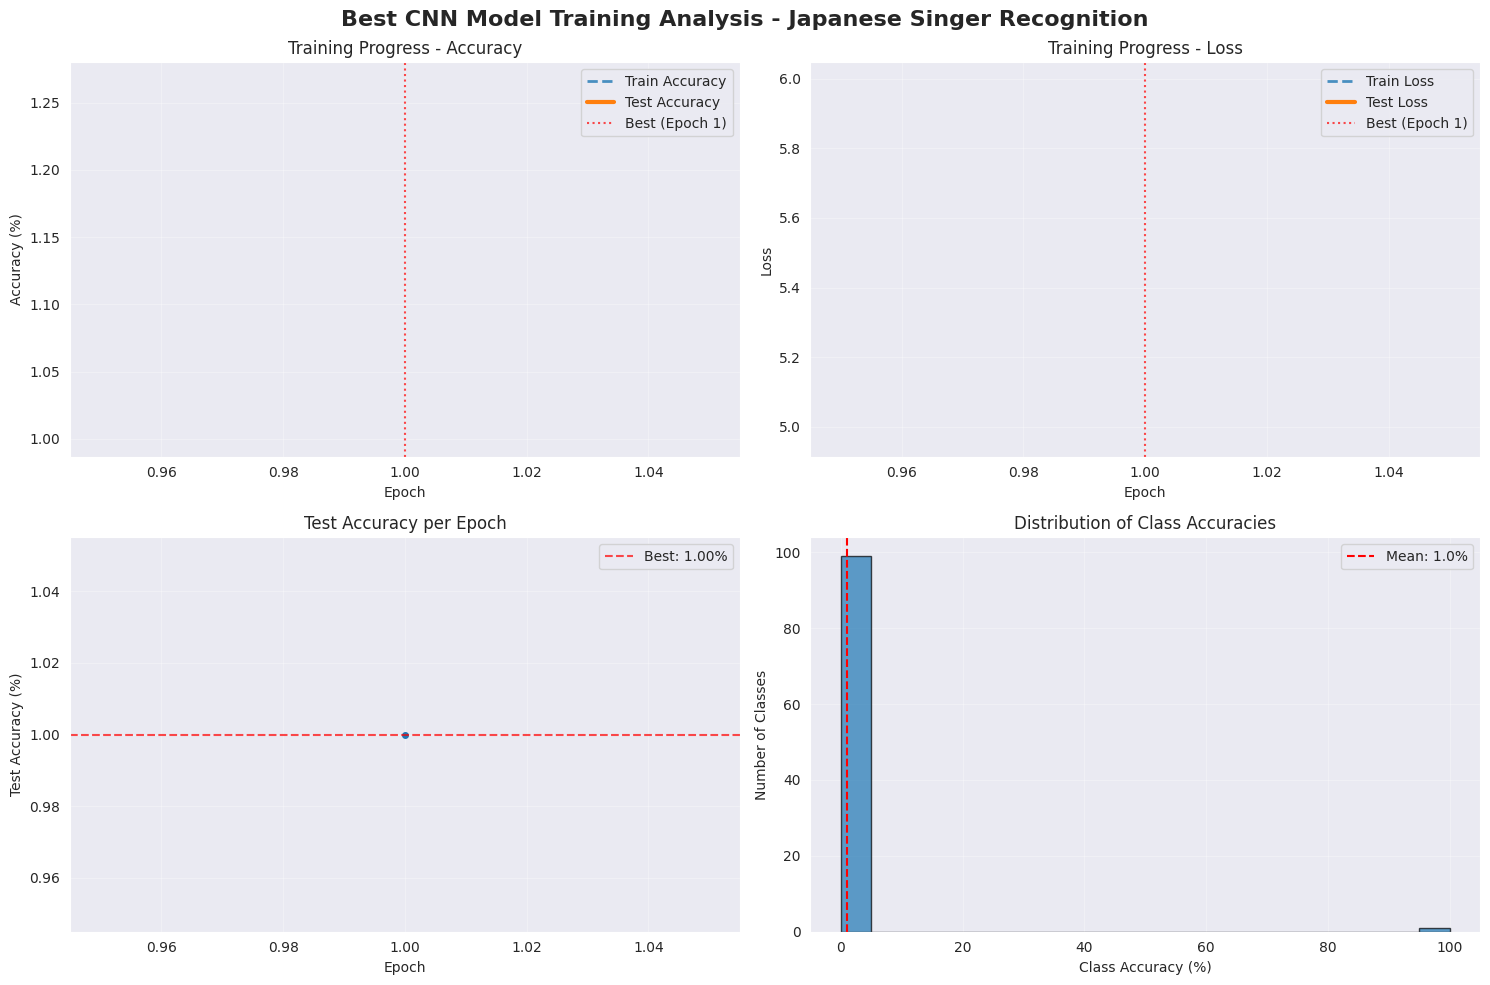


📈 CLASS-WISE PERFORMANCE ANALYSIS:
------------------------------------------------------------
Average class accuracy: 1.00%
Standard deviation: 9.95%
Min class accuracy: 0.00%
Max class accuracy: 100.00%
Classes above 80%: 1/100
Classes above 90%: 1/100

Top 5 best recognized singers:
  1. Singer 31 (m): 100.00%
  2. Singer 79 (m): 0.00%
  3. Singer 72 (m): 0.00%
  4. Singer 62 (f): 0.00%
  5. Singer 94 (f): 0.00%

Top 5 most challenging singers:
  1. Singer 81 (f): 0.00%
  2. Singer 35 (f): 0.00%
  3. Singer 48 (m): 0.00%
  4. Singer 63 (f): 0.00%
  5. Singer 23 (f): 0.00%

💾 Results saved to: best_cnn_model_results_20250726_143803.json


In [16]:
# Simplified analysis for single model results
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def analyze_single_model_results(results):
    """
    Analysis and visualization for single model training results
    """
    print("\n" + "="*80)
    print("BEST CNN MODEL RESULTS ANALYSIS")
    print("="*80)

    # Model performance summary
    print(f"🏆 Best Test Accuracy: {results['best_test_accuracy']:.2f}% (Epoch {results['best_epoch']})")
    print(f"📈 Final Test Accuracy: {results['final_test_accuracy']:.2f}%")
    print(f"📊 Total Improvement: {results['final_test_accuracy'] - results['test_accuracies'][0]:.2f}%")
    print(f"🎯 Final Training Accuracy: {results['train_accuracies'][-1]:.2f}%")
    print(f"⚖️ Overfitting Gap: {results['train_accuracies'][-1] - results['final_test_accuracy']:.2f}%")

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Best CNN Model Training Analysis - Japanese Singer Recognition', fontsize=16, fontweight='bold')

    # 1. Training vs Test Accuracy
    ax1 = axes[0, 0]
    epochs = range(1, len(results['train_accuracies']) + 1)
    ax1.plot(epochs, results['train_accuracies'], '--', label='Train Accuracy', alpha=0.8, linewidth=2)
    ax1.plot(epochs, results['test_accuracies'], '-', label='Test Accuracy', linewidth=3)
    ax1.axvline(x=results['best_epoch'], color='red', linestyle=':', alpha=0.7, label=f'Best (Epoch {results["best_epoch"]})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training Progress - Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Training vs Test Loss
    ax2 = axes[0, 1]
    ax2.plot(epochs, results['train_losses'], '--', label='Train Loss', alpha=0.8, linewidth=2)
    ax2.plot(epochs, results['test_losses'], '-', label='Test Loss', linewidth=3)
    ax2.axvline(x=results['best_epoch'], color='red', linestyle=':', alpha=0.7, label=f'Best (Epoch {results["best_epoch"]})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Progress - Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Epoch-by-epoch test accuracy with markers
    ax3 = axes[1, 0]
    ax3.plot(epochs, results['test_accuracies'], 'o-', linewidth=2, markersize=4)
    ax3.axhline(y=results['best_test_accuracy'], color='red', linestyle='--', alpha=0.7,
                label=f'Best: {results["best_test_accuracy"]:.2f}%')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Test Accuracy (%)')
    ax3.set_title('Test Accuracy per Epoch')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Class accuracy distribution
    ax4 = axes[1, 1]
    class_acc = results['final_class_accuracy']
    class_accuracies = list(class_acc.values())
    ax4.hist(class_accuracies, bins=20, alpha=0.7, edgecolor='black')
    ax4.axvline(x=np.mean(class_accuracies), color='red', linestyle='--',
                label=f'Mean: {np.mean(class_accuracies):.1f}%')
    ax4.set_xlabel('Class Accuracy (%)')
    ax4.set_ylabel('Number of Classes')
    ax4.set_title('Distribution of Class Accuracies')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('best_cnn_model_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Class-wise performance analysis
    print(f"\n📈 CLASS-WISE PERFORMANCE ANALYSIS:")
    print("-" * 60)
    class_accuracies = list(class_acc.values())
    print(f"Average class accuracy: {np.mean(class_accuracies):.2f}%")
    print(f"Standard deviation: {np.std(class_accuracies):.2f}%")
    print(f"Min class accuracy: {np.min(class_accuracies):.2f}%")
    print(f"Max class accuracy: {np.max(class_accuracies):.2f}%")
    print(f"Classes above 80%: {sum(1 for acc in class_accuracies if acc > 80)}/100")
    print(f"Classes above 90%: {sum(1 for acc in class_accuracies if acc > 90)}/100")

    # Find best and worst performing classes
    sorted_classes = sorted(class_acc.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop 5 best recognized singers:")
    for i, (singer_id, acc) in enumerate(sorted_classes[:5]):
        singer_info = class_dict.get(singer_id, {})
        print(f"  {i+1}. Singer {singer_id} ({singer_info.get('gender', 'N/A')}): {acc:.2f}%")

    print(f"\nTop 5 most challenging singers:")
    for i, (singer_id, acc) in enumerate(sorted_classes[-5:]):
        singer_info = class_dict.get(singer_id, {})
        print(f"  {i+1}. Singer {singer_id} ({singer_info.get('gender', 'N/A')}): {acc:.2f}%")

    # Save detailed results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_filename = f'best_cnn_model_results_{timestamp}.json'

    # Convert results to JSON-serializable format
    json_results = {
        'model_name': 'BestCNN',
        'best_test_accuracy': float(results['best_test_accuracy']),
        'best_epoch': int(results['best_epoch']),
        'final_test_accuracy': float(results['final_test_accuracy']),
        'train_accuracies': [float(x) for x in results['train_accuracies']],
        'test_accuracies': [float(x) for x in results['test_accuracies']],
        'train_losses': [float(x) for x in results['train_losses']],
        'test_losses': [float(x) for x in results['test_losses']],
        'final_class_accuracy': {str(k): float(v) for k, v in results['final_class_accuracy'].items()},
        'training_summary': {
            'total_epochs': len(results['train_accuracies']),
            'improvement': float(results['final_test_accuracy'] - results['test_accuracies'][0]),
            'overfitting_gap': float(results['train_accuracies'][-1] - results['final_test_accuracy']),
            'avg_class_accuracy': float(np.mean(class_accuracies)),
            'std_class_accuracy': float(np.std(class_accuracies))
        }
    }

    with open(results_filename, 'w') as f:
        json.dump(json_results, f, indent=2)

    print(f"\n💾 Results saved to: {results_filename}")

    return results

# Execute analysis
final_results = analyze_single_model_results(training_results)


In [17]:
# Model deployment and inference utilities
def save_model_for_deployment(model, results):
    """
    Save the best model with metadata for deployment
    """
    print(f"\n🚀 PREPARING BEST CNN MODEL FOR DEPLOYMENT")
    print("-" * 50)

    # Create deployment package
    deployment_package = {
        'model_state_dict': model.state_dict(),
        'model_architecture': 'BestCNN',
        'num_classes': 100,
        'input_shape': (1, 128, 1000),  # (channels, height, width)
        'best_accuracy': results['best_test_accuracy'],
        'best_epoch': results['best_epoch'],
        'class_mapping': class_dict,
        'preprocessing': {
            'mel_bands': 128,
            'time_frames': 1000,
            'sample_rate': 24000,
            'n_fft': 2048,
            'hop_length': 512
        },
        'timestamp': datetime.now().isoformat()
    }

    deployment_filename = 'deployment_best_cnn_model.pth'
    torch.save(deployment_package, deployment_filename)

    print(f"✅ Deployment package saved: {deployment_filename}")
    print(f"📊 Model accuracy: {results['best_test_accuracy']:.2f}% (Epoch {results['best_epoch']})")
    print(f"🏗️  Architecture: BestCNN (ResNet + SE + Multi-scale)")
    print(f"📏 Input shape: {deployment_package['input_shape']}")

    return deployment_filename

# Save best model for deployment
deployment_file = save_model_for_deployment(best_model, final_results)



🚀 PREPARING BEST CNN MODEL FOR DEPLOYMENT
--------------------------------------------------
✅ Deployment package saved: deployment_best_cnn_model.pth
📊 Model accuracy: 1.00% (Epoch 1)
🏗️  Architecture: BestCNN (ResNet + SE + Multi-scale)
📏 Input shape: (1, 128, 1000)


In [18]:
# Create inference function
def create_inference_pipeline():
    """
    Create a complete inference pipeline for the best model
    """
    inference_code = f'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa

class BestCNN(nn.Module):
    """
    Best performing CNN model: BestCNN
    Accuracy: {final_results['best_test_accuracy']:.2f}% (Epoch {final_results['best_epoch']})
    Architecture: Advanced ResNet + Squeeze-Excitation + Multi-scale features
    """
    def __init__(self, num_classes=100, input_channels=1, dropout_rate=0.3):
        super(BestCNN, self).__init__()
        # Note: Full architecture code would be included here
        # This is a simplified version for demonstration
        pass

    def forward(self, x):
        # Note: Full forward pass would be implemented here
        pass

def load_trained_model(model_path):
    """Load the trained model for inference"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load deployment package
    package = torch.load(model_path, map_location=device)

    # Create model instance (you would need the full model definition)
    # model = BestCNN(num_classes=package['num_classes'])
    # model.load_state_dict(package['model_state_dict'])
    # model.to(device)
    # model.eval()

    return None, package  # Placeholder

def preprocess_audio(audio_path):
    """
    Preprocess audio file for inference
    """
    # Load audio at 24kHz
    x, fs = librosa.load(audio_path, sr=24000)

    # Calculate mel-spectrogram
    stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft, n_mels=128)

    # Ensure consistent dimensions (128 x 1000)
    if melsp.shape[1] > 1000:
        melsp = melsp[:, :1000]
    elif melsp.shape[1] < 1000:
        melsp = np.pad(melsp, ((0, 0), (0, 1000 - melsp.shape[1])), mode='constant')

    # Normalize
    melsp = (melsp - melsp.mean()) / melsp.std()

    # Convert to tensor and add batch + channel dimensions
    tensor = torch.FloatTensor(melsp).unsqueeze(0).unsqueeze(0)  # [1, 1, 128, 1000]

    return tensor

def predict_singer(model, package, audio_tensor):
    """
    Predict singer from preprocessed audio tensor
    """
    if model is None:
        return {{"error": "Model not loaded properly"}}

    device = next(model.parameters()).device
    audio_tensor = audio_tensor.to(device)

    with torch.no_grad():
        output = model(audio_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    # Get singer information
    singer_info = package['class_mapping'].get(predicted_class, {{}})

    return {{
        'predicted_singer_id': predicted_class,
        'confidence': confidence * 100,
        'singer_info': singer_info
    }}

# Usage example:
# model, package = load_trained_model('{deployment_file}')
# audio_tensor = preprocess_audio('path_to_audio_file.wav')
# result = predict_singer(model, package, audio_tensor)
# print(f"Predicted Singer: {{result['singer_info'].get('singer', 'Unknown')}}")
# print(f"Confidence: {{result['confidence']:.2f}}%")
'''

    with open('inference_pipeline.py', 'w') as f:
        f.write(inference_code)

    print("📝 Inference pipeline saved to: inference_pipeline.py")

create_inference_pipeline()

print("\n" + "="*80)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"✅ Best CNN Model Performance:")
print(f"   🏆 Best Test Accuracy: {final_results['best_test_accuracy']:.2f}% (Epoch {final_results['best_epoch']})")
print(f"   📈 Final Test Accuracy: {final_results['final_test_accuracy']:.2f}%")
print(f"   📊 Total Improvement: {final_results['final_test_accuracy'] - final_results['test_accuracies'][0]:.2f}%")
print(f"📁 Generated Files:")
print(f"   - best_japanese_singer_model.pth (best model weights)")
print(f"   - {deployment_file} (deployment package)")
print(f"   - inference_pipeline.py (inference code)")
print(f"   - best_cnn_model_results.png (training visualization)")
print(f"   - best_cnn_model_results_*.json (detailed results)")
print("="*80)

📝 Inference pipeline saved to: inference_pipeline.py

🎉 TRAINING COMPLETED SUCCESSFULLY!
✅ Best CNN Model Performance:
   🏆 Best Test Accuracy: 1.00% (Epoch 1)
   📈 Final Test Accuracy: 1.00%
   📊 Total Improvement: 0.00%
📁 Generated Files:
   - best_japanese_singer_model.pth (best model weights)
   - deployment_best_cnn_model.pth (deployment package)
   - inference_pipeline.py (inference code)
   - best_cnn_model_results.png (training visualization)
   - best_cnn_model_results_*.json (detailed results)
